In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tsai.all import *
from tsai.inference import load_learner

/home/salva/anaconda3/envs/traffic-analyzer/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


> En este *notebook* se entrena un modelo LSTM para predecir las 24 horas siguientes.

### Importa los datos

In [2]:
df = pd.read_csv("ts_tv08.csv")
df["datetime"] = pd.to_datetime(df["datetime"])
df = df.set_index("datetime")
df = df.resample("5T").median().ffill().astype(float)

### Entrena el modelo para predecir 24 horas

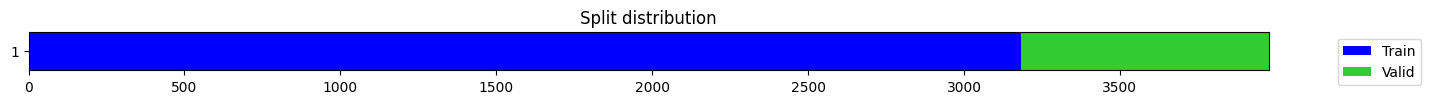

epoch,train_loss,valid_loss,mae,time


In [ ]:
ts = df
window_len = 10
horizon = 10
X, y = SlidingWindow(window_len=window_len, horizon=horizon)(ts)
splits = TimeSplitter()(y) 
batch_tfms = TSStandardize()
fcst = TSForecaster(X, y, splits=splits, batch_tfms=batch_tfms, bs=64, arch=LSTMPlus, metrics=mae, cbs=ShowGraph())
fcst.fit_one_cycle(2, 1e-3)
fcst.export("tv-08.pkl")
df = df.astype(int)

### Predice 24 horas siguientes

In [ ]:
fcst = load_learner("tv-08.pkl", cpu=False)
X_test = array([[(df["n_vehicles"][-window_len:]).values]])
raw_preds, target, preds = fcst.get_X_preds(X_test)
preds = [int(item) for item in preds[0]]

### Gráfica de las predicciones

In [ ]:
fig, axis = plt.subplots(facecolor="white", figsize=(18, 8))
axis.grid()
axis.set_xlabel(xlabel="Fecha")
axis.set_ylabel(ylabel="Vehículos")
axis.set_facecolor("gainsboro")
last_date = df.index.max()
freq = "5T"
horizon = len(preds)
new_dates = pd.date_range(start=last_date, periods=horizon + 1, freq=freq, closed="right")
axis.plot(df, label="observación")
axis.plot(new_dates, preds, color="red", label="predicción")